In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import os, sys
import ruamel.yaml as yaml
from scipy.stats import mannwhitneyu,ks_2samp

plot_dir = "/Users/eric/repos/gohr/misc/ml_plots/neurips/"

if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

In [2]:
class SafeLoaderIgnoreUnknown(yaml.SafeLoader):
    def ignore_unknown(self, node):
        return None 

SafeLoaderIgnoreUnknown.add_constructor(None, SafeLoaderIgnoreUnknown.ignore_unknown)

# Location of rule runs
#rule_runs_path = "/Users/eric/repos/gohr/active/outputs/neurips_2023/dqn_500_500/"
rule_runs_path = "/Users/eric/repos/gohr/active/outputs/500_test/"
cluster_runs = [name for name in os.listdir(rule_runs_path) if name!=".DS_Store"]
runs_to_analyze = ["naive_bd_ad_n2","naive_bd_ad_n4","naive_bd_ad_n6","naive_bd_ad_n8",
                   "naive_bs_ad_n2","naive_bs_ad_n4","naive_bs_ad_n6","naive_bs_ad_n8",
                   "naive_bd_as_n2","naive_bd_as_n4","naive_bd_as_n6","naive_bd_as_n8",
                   "naive_bda_as_n2","naive_bda_as_n4","naive_bda_as_n6","naive_bda_as_n8",
                   "naive_bs_as_n2","naive_bs_as_n4","naive_bs_as_n6","naive_bs_as_n8",
                   "naive_bsd_asd_n2","naive_bsd_asd_n4","naive_bsd_asd_n6","naive_bsd_asd_n8"]

# Create lists that will hold dataframes for concatenation
episode_df_list = []
terminal_results_list = []
placeholder_value = np.nan
delta_horizon=150
# Loop over the specified rule runs
for cluster_run in cluster_runs:
    cluster_run_path = rule_runs_path+cluster_run+"/"
    for run in runs_to_analyze:
        # Form complete run path
        run_path = cluster_run_path+run
        # Get the experiments for that run (each one is a set of trials for a particular rule)
        experiments = [name for name in os.listdir(run_path) if name!=".DS_Store"]

        # Loop over the experiments
        for experiment in experiments:
            # Get the cluster id
            cluster_trial = experiment.split("_")[0]
            cluster_process = experiment.split("_")[1]
            cluster_id = cluster_trial+"_"+cluster_process
            # String length may vary
            id_str_length = len(cluster_id)
            # Get the corresponding rule name
            rule_name = experiment[id_str_length+1:]
            # For complete experiment path
            experiment_path = os.path.join(run_path,experiment)
            
            trials = [name for name in os.listdir(experiment_path) if name!=".DS_Store"]

            for trial in trials:
                trial_path = os.path.join(experiment_path,trial)
                # Get parameters
                yaml_path = os.path.join(trial_path,"data.yaml")
                with open(yaml_path, 'r') as param_file:
                    args = yaml.load(param_file, Loader=SafeLoaderIgnoreUnknown)
                    featurization =args["FEATURIZATION"]
                # Import episodic data and process relevant columns
                episodic_data_path = os.path.join(trial_path,"episode_data.csv")
                trial_results = pd.read_csv(episodic_data_path)
                #move_results = pd.read_csv(move_data_path,index_col=0,usecols=['episode','time','reward'])
                
                # Episode processing
                trial_results["rule"]=rule_name
                trial_results["params"]=run
                trial_results["memory"]=int(run[-1])
                trial_results["experiment_id"]=cluster_id
                trial_results["trial"]=trial
                trial_results["featurization"]=featurization
                trial_results["ep_error"]=-1*trial_results["reward"]
                trial_results["cumulative_error"] = trial_results.ep_error.cumsum()
                #if trial_results.episode.max()!=1999:
                    #print(trial_results.cluster_id.unique())
                #    continue
                delta_horizon_err_val = trial_results.cumulative_error.iloc[-delta_horizon]
                delta = trial_results.cumulative_error.iloc[-1]-trial_results.cumulative_error.iloc[-delta_horizon]
                #trial_results["100_ep_delta"]=delta
                converged = (delta/(delta_horizon*9+delta))<0.001
                #trial_results["converged"]=converged
                term_entry = trial_results.iloc[-1].to_frame().transpose()
                tce = term_entry.cumulative_error
                term_entry["converged"]=converged
                if converged:
                    adj_error=tce
                else:
                    adj_error=placeholder_value
                term_entry["adj_cumulative_error"]=adj_error
                term_entry["delta"]=delta
                term_entry['horizon_err']=delta_horizon_err_val
                terminal_results_list.append(term_entry)
                test_ser = trial_results.iloc[-1]
                episode_df_list.append(trial_results)
            
# Concatenate everything into one dataframe
episode_results_df = pd.concat(episode_df_list,ignore_index=True)
terminal_results_df = pd.concat(terminal_results_list,ignore_index=True)

In [3]:
terminal_results_df.head()

,episode,reward,rule,params,memory,experiment_id,trial,featurization,ep_error,cumulative_error,converged,adj_cumulative_error,delta,horizon_err
0,1999,0.0,1_1_color_3m_cua,naive_bd_ad_n2,2,10993620_256,0,NAIVE_N_BD_AD,-0.0,936.0,True,936.0,1.0,935.0
1,1999,0.0,1_1_color_3m_cua,naive_bd_ad_n2,2,10993620_256,1,NAIVE_N_BD_AD,-0.0,967.0,True,967.0,0.0,967.0
2,1999,0.0,1_1_color_3m_cua,naive_bd_ad_n2,2,10993620_256,4,NAIVE_N_BD_AD,-0.0,1027.0,True,1027.0,0.0,1027.0
3,1999,0.0,1_1_color_3m_cua,naive_bd_ad_n2,2,10993620_256,3,NAIVE_N_BD_AD,-0.0,1039.0,True,1039.0,0.0,1039.0
4,1999,0.0,1_1_color_3m_cua,naive_bd_ad_n2,2,10993620_256,2,NAIVE_N_BD_AD,-0.0,1029.0,True,1029.0,0.0,1029.0


In [4]:
# Rule name replacement
episode_results_df.replace(to_replace={ '1_1_shape_4m':'SM','1_2_shape_4m':'SM2O','1_1_shape_3m_cua':'SM1F',
                                '1_1_color_4m':'CM','1_2_color_4m':'CM2O','1_1_color_3m_cua':'CM1F',
                                'clockwiseZeroStart':'CW','clockwiseTwoFreeAlt':'CWAF','clockwiseTwoFree':'CW2F',
                                'quadrantNearby':'QN','quadrantNearbyTwoFree':'QN2F',
                                'bottomLeft_then_topRight':'BLTR','bottom_then_top':'BT'},inplace=True)
terminal_results_df.replace(to_replace={ '1_1_shape_4m':'SM','1_2_shape_4m':'SM2O','1_1_shape_3m_cua':'SM1F',
                                '1_1_color_4m':'CM','1_2_color_4m':'CM2O','1_1_color_3m_cua':'CM1F',
                                'clockwiseZeroStart':'CW','clockwiseTwoFreeAlt':'CWAF','clockwiseTwoFree':'CW2F',
                                'quadrantNearby':'QN','quadrantNearbyTwoFree':'QN2F',
                                'bottomLeft_then_topRight':'BLTR','bottom_then_top':'BT'},inplace=True)

# Featurization replacement
episode_results_df.replace(to_replace={ 'NAIVE_N_BD_AD':'BD_AD',
                                        'NAIVE_N_BD_AS':'BD_AS',
                                        'NAIVE_N_BS_AD':'BS_AD',
                                        'NAIVE_N_BS_AS':'BS_AS',
                                        'NAIVE_N_BDa_AS':'BDa_AS',
                                        'NAIVE_N_BSD_ASD':'BSD_ASD'
                                        },inplace=True)
terminal_results_df.replace(to_replace={ 'NAIVE_N_BD_AD':'BD_AD',
                                        'NAIVE_N_BD_AS':'BD_AS',
                                        'NAIVE_N_BS_AD':'BS_AD',
                                        'NAIVE_N_BS_AS':'BS_AS',
                                        'NAIVE_N_BDa_AS':'BDa_AS',
                                        'NAIVE_N_BSD_ASD':'BSD_ASD'
                                        },inplace=True)

In [5]:
# DQN
complete_list = episode_results_df.rule.unique()
# rules_list = [#{"name":"all_rules","rules":complete_list,"y":[0,4000]},
#                 #{"name":"quick_test","rules":["1_1_shape_4m","1_2_shape_4m"],"y":[0,2500]}
#                 #{"name":"base_rules","rules":["1_1_shape_4m","clockwiseZeroStart","quadrantNearby","bottomLeft_then_topRight"],"y":[0,4000]},
#                 {"name":"shape_rules","rules":["1_1_shape_4m","1_1_shape_3m_cua","1_2_shape_4m"],"y":[0,2500]},
#                 {"name":"color_rules","rules":["1_1_color_4m","1_1_color_3m_cua","1_2_color_4m"],"y":[0,2500]}, 
#                 {"name":"clockwise_rules","rules":["clockwiseZeroStart","clockwiseTwoFreeAlt","clockwiseTwoFree"],"y":[0,4000]},
#                 {"name":"quadrant_rules","rules":["quadrantNearby","quadrantNearbyTwoFree"],"y":[0,400]},
#                 {"name":"bottom_top_rules","rules":["bottomLeft_then_topRight","bottom_then_top"],"y":[0,1500]}
#                 ]
rules_list = [#{"name":"all_rules","rules":complete_list,"y":[0,4000]},
                #{"name":"quick_test","rules":["1_1_shape_4m","1_2_shape_4m"],"y":[0,2500]}
                #{"name":"base_rules","rules":["1_1_shape_4m","clockwiseZeroStart","quadrantNearby","bottomLeft_then_topRight"],"y":[0,4000]},
                {"name":"shape_rules","rules":["SM","SM1F","SM2O"],"y":[0,4000]},
                {"name":"color_rules","rules":["CM","CM1F","CM2O"],"y":[0,4000]}, 
                {"name":"clockwise_rules","rules":["CW","CWAF","CW2F"],"y":[0,4000]},
                {"name":"quadrant_rules","rules":["QN","QN2F"],"y":[0,400]},
                {"name":"bottom_top_rules","rules":["BLTR","BT"],"y":[0,1500]}
                ]

steps = terminal_results_df.memory.unique()
print(steps)
gs = GridSpec(nrows = len(rules_list),ncols=len(steps))
#feats = ["NAIVE_N_BD_AD","NAIVE_N_BS_AD","NAIVE_N_BD_AS","NAIVE_N_BDa_AS","NAIVE_N_BS_AS", "NAIVE_N_BSD_ASD"]
feats = ["BD_AD","BS_AD","BD_AS","BDa_AS","BS_AS", "BSD_ASD"]

[2 4 6 8]


In [6]:
reduced_results = episode_results_df.query("episode%20==0")
reduced_results.head()

,episode,reward,rule,params,memory,experiment_id,trial,featurization,ep_error,cumulative_error
0,0,-16.0,CM1F,naive_bd_ad_n2,2,10993620_256,0,BD_AD,16.0,16.0
20,20,-15.0,CM1F,naive_bd_ad_n2,2,10993620_256,0,BD_AD,15.0,301.0
40,40,-8.0,CM1F,naive_bd_ad_n2,2,10993620_256,0,BD_AD,8.0,546.0
60,60,-2.0,CM1F,naive_bd_ad_n2,2,10993620_256,0,BD_AD,2.0,675.0
80,80,0.0,CM1F,naive_bd_ad_n2,2,10993620_256,0,BD_AD,-0.0,747.0


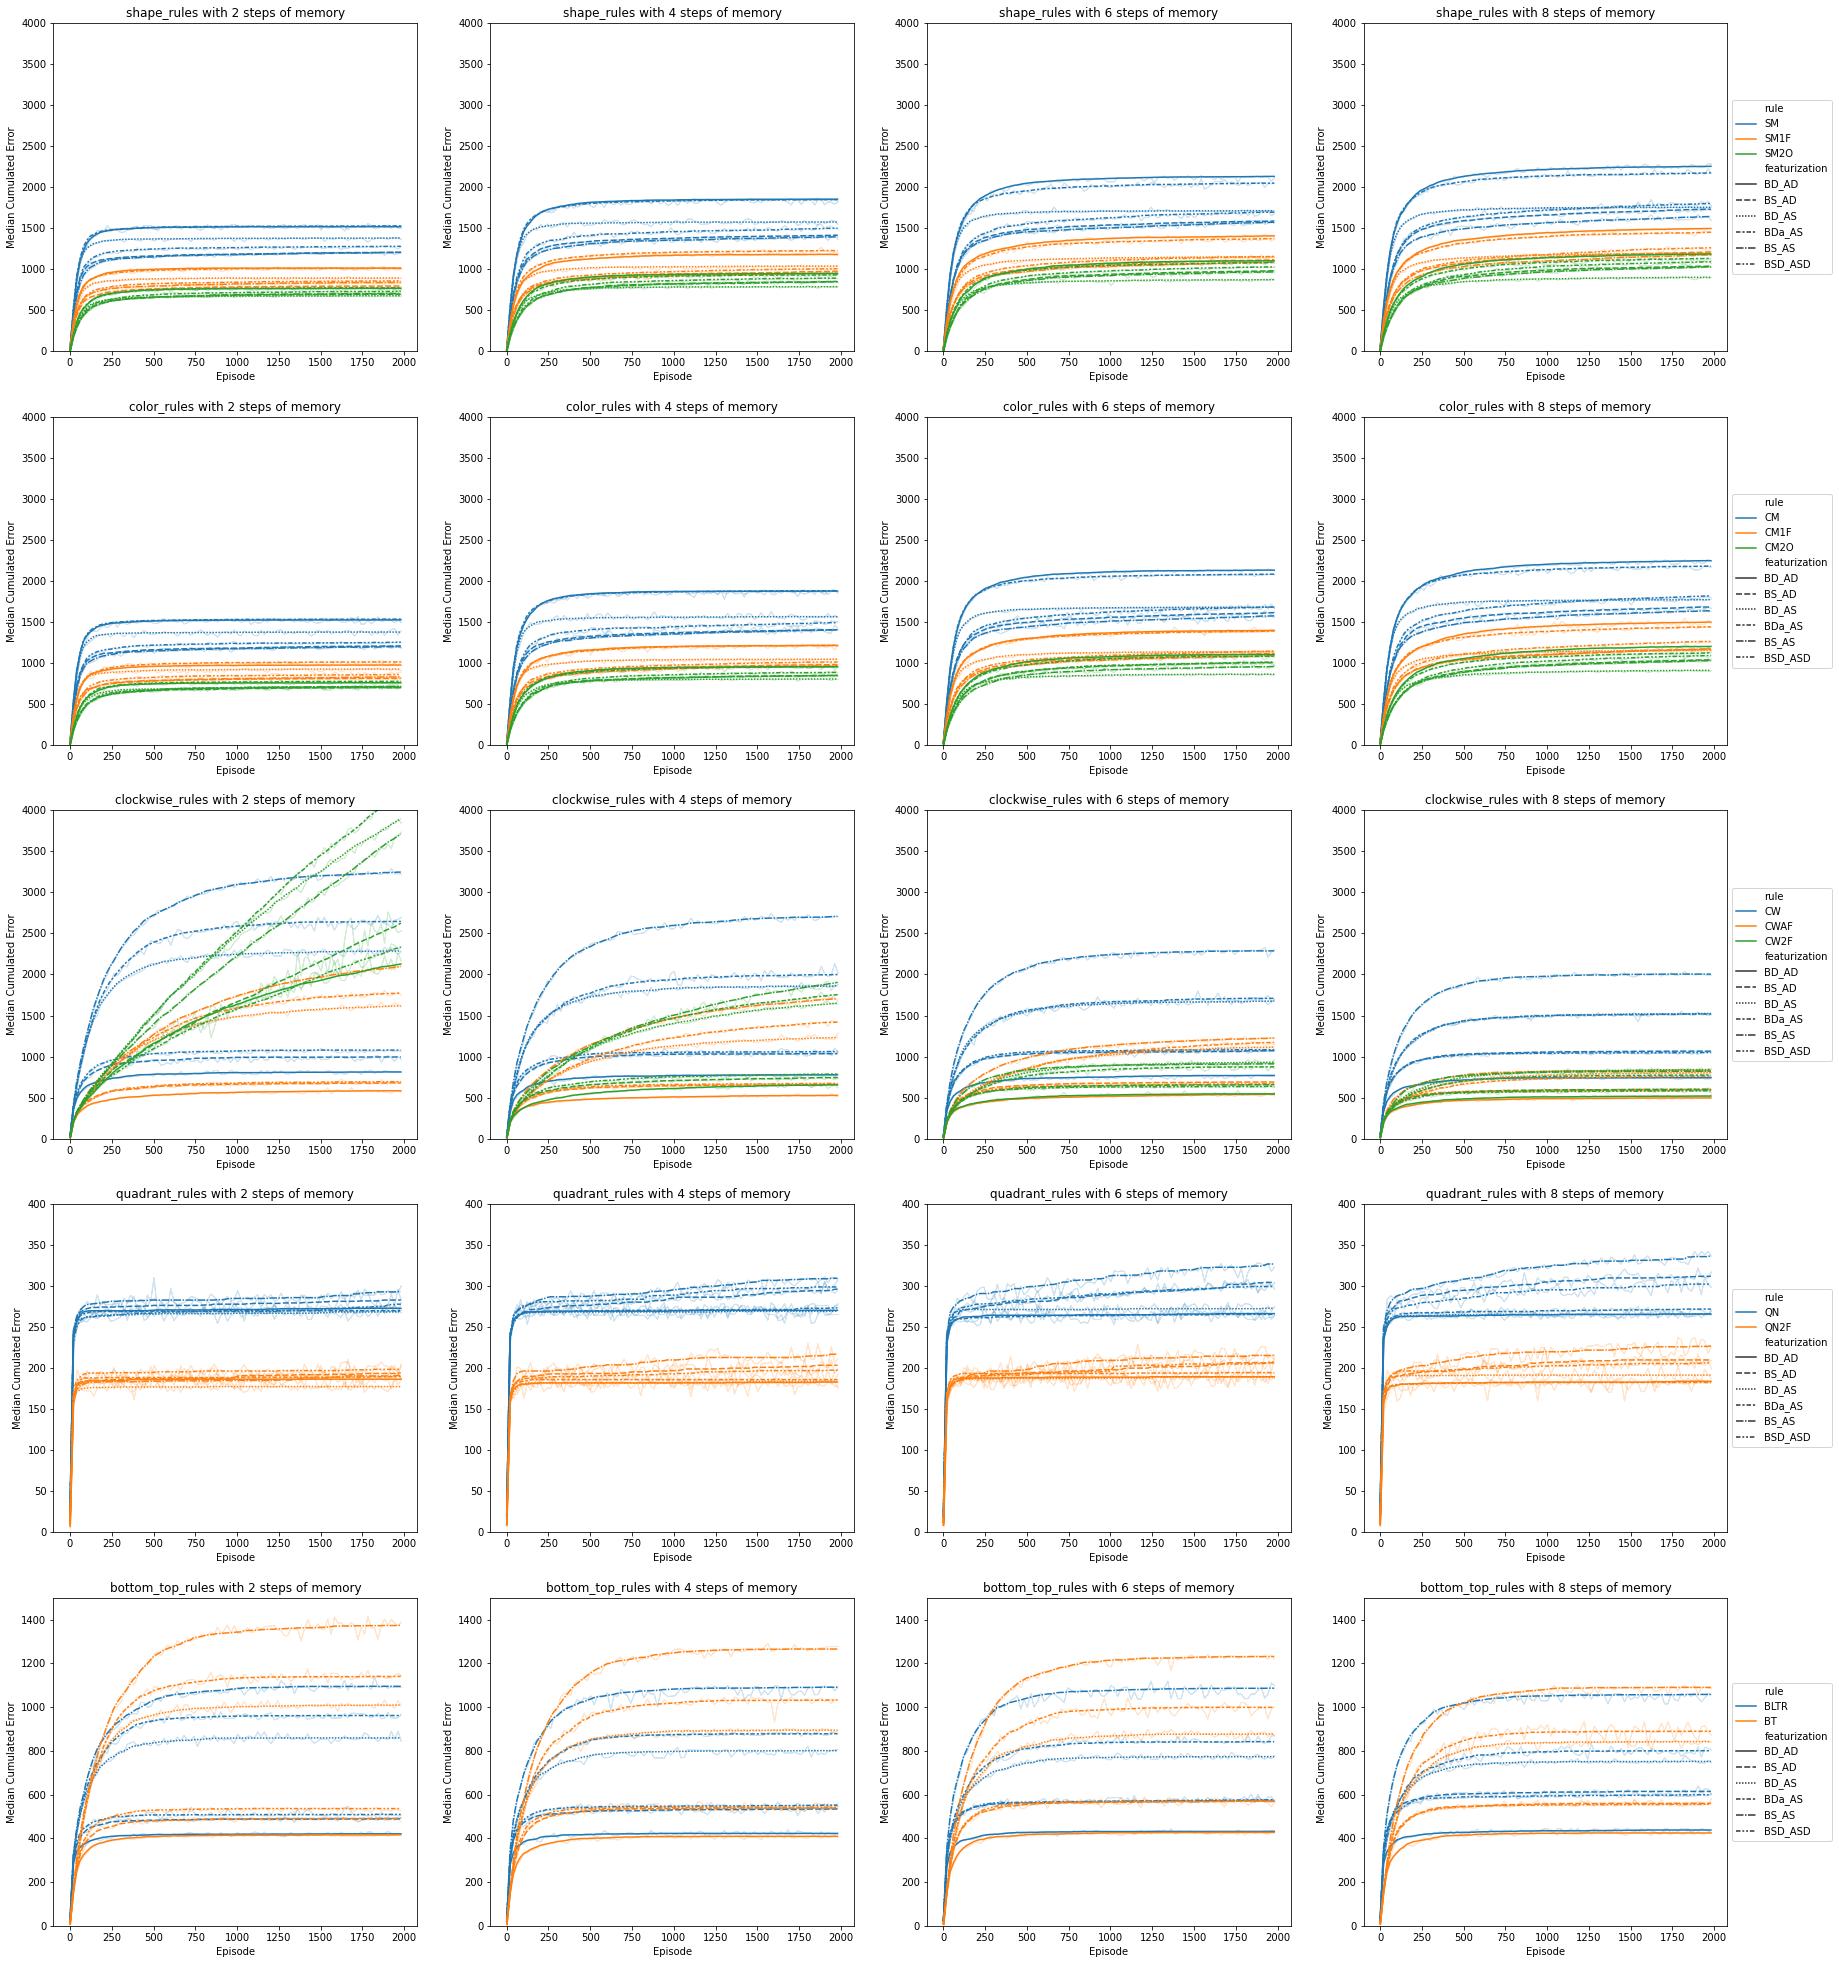

In [7]:
# Create a figure grid for all results
fig = plt.figure(figsize=(30,35))
for idx,step in enumerate(steps):
    #results_df = episode_results_df[episode_results_df.memory==step]
    results_df = reduced_results[reduced_results.memory==step]
    for i in range(len(rules_list)):
        sub_dict = rules_list[i]
        sub_list = sub_dict["rules"]
        name = sub_dict["name"]
        ax = fig.add_subplot(gs[i,idx])
        if not(step==8):
            ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode",errorbar=("ci",95),n_boot=1, estimator=np.median,hue="rule",hue_order=sub_list,style="featurization",style_order=feats,legend=False)
        else:
            ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode",errorbar=("ci",95),n_boot=1, estimator=np.median,hue="rule",hue_order=sub_list,style="featurization",style_order=feats)
            #errorbar=("ci",95),n_boot=1
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_title(name+" with {} steps of memory".format(str(step)))
        ax.set_ylim(np.array(sub_dict["y"]))
        ax.set_ylabel("Median Cumulated Error")
        ax.set_xlabel("Episode")
plt.savefig(plot_dir+'dqn_500_500_ml_6_ways.pdf',bbox_inches='tight',facecolor='w')
#plt.savefig(plot_dir+'ml_6_ways_base_rules.pdf',bbox_inches='tight',facecolor='w')

In [8]:
display(terminal_results_df.query("memory==8 & featurization=='BS_AS' & rule=='QN'"))

,episode,reward,rule,params,memory,experiment_id,trial,featurization,ep_error,cumulative_error,converged,adj_cumulative_error,delta,horizon_err
2555,1999,0.0,QN,naive_bs_as_n8,8,10993620_471,0,BS_AS,-0.0,345.0,False,NaN,6.0,339.0
2556,1999,0.0,QN,naive_bs_as_n8,8,10993620_471,1,BS_AS,-0.0,337.0,False,NaN,2.0,335.0
2557,1999,0.0,QN,naive_bs_as_n8,8,10993620_471,4,BS_AS,-0.0,343.0,True,343.0,0.0,343.0
2558,1999,0.0,QN,naive_bs_as_n8,8,10993620_471,3,BS_AS,-0.0,329.0,True,329.0,0.0,329.0
2559,1999,0.0,QN,naive_bs_as_n8,8,10993620_471,2,BS_AS,-0.0,343.0,True,343.0,0.0,343.0
2570,1999,0.0,QN,naive_bs_as_n8,8,10993620_470,0,BS_AS,-0.0,337.0,True,337.0,1.0,336.0
2571,1999,0.0,QN,naive_bs_as_n8,8,10993620_470,1,BS_AS,-0.0,330.0,True,330.0,0.0,330.0
2572,1999,0.0,QN,naive_bs_as_n8,8,10993620_470,4,BS_AS,-0.0,353.0,False,NaN,2.0,351.0
2573,1999,0.0,QN,naive_bs_as_n8,8,10993620_470,3,BS_AS,-0.0,318.0,True,318.0,0.0,318.0
2574,1999,0.0,QN,naive_bs_as_n8,8,10993620_470,2,BS_AS,-0.0,330.0,True,330.0,0.0,330.0


In [9]:
# complete_rules = ["1_1_shape_4m","1_1_shape_3m_cua","1_2_shape_4m",
#                 "1_1_color_4m","1_1_color_3m_cua","1_2_color_4m", 
#                 "clockwiseZeroStart","clockwiseTwoFreeAlt","clockwiseTwoFree",
#                 "quadrantNearby","quadrantNearbyTwoFree",
#                 "bottomLeft_then_topRight","bottom_then_top"]
complete_rules = ["SM","SM1F","SM2O","CM","CM1F","CM2O","QN","QN2F","BLTR","BT","CW","CWAF","CW2F"]
base_rules = ["SM","CM","QN","BLTR","CW"]
steps = [2,4,6,8]

['SM', 'SM1F', 'SM2O', 'CM', 'CM1F', 'CM2O', 'QN', 'QN2F', 'BLTR', 'BT', 'CW', 'CWAF', 'CW2F']


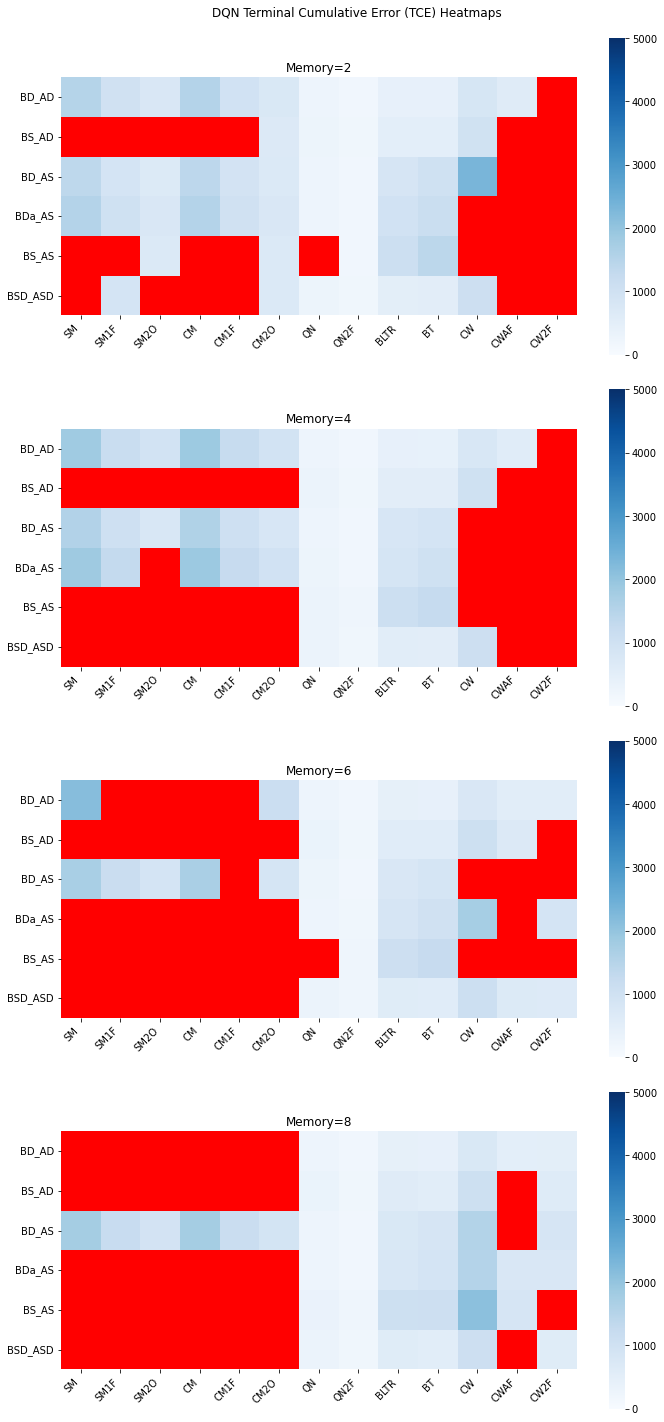

In [10]:
chosen_rules = complete_rules
num_feats = len(feats)
num_rules = len(chosen_rules)
num_steps = len(steps)
tce_heatmap = np.empty((num_steps,num_feats,num_rules))

for i in range(num_feats):
    curr_feat = feats[i]
    for j in range(num_rules):
        curr_rule = chosen_rules[j]
        for k in range(num_steps):
            curr_step = steps[k]
            curr_df = terminal_results_df.query("rule==@curr_rule & featurization==@curr_feat & memory==@curr_step").copy().fillna(50000)
            errors = curr_df.adj_cumulative_error.to_numpy(copy=True)
            med_err = np.median(errors)
            tce_heatmap[k][i][j]=med_err
print(chosen_rules)

fig = plt.figure(figsize=(10,20))
gs = GridSpec(nrows = len(steps),ncols=1)
green = sns.light_palette("seagreen", reverse=True, as_cmap=True)
blue = sns.color_palette("Blues",as_cmap=True)
blue.set_over('red')
for i,step in enumerate(steps):
    ax = fig.add_subplot(gs[i,0])
    sns.heatmap(ax=ax,data=tce_heatmap[i],cmap=blue,vmin=0,vmax=5000,yticklabels=feats,xticklabels=chosen_rules,square=True)#,annot=True,yticklabels=sorted_rules_labeled,linewidth=.5,vmin=0,vmax=alpha/comparisons,cmap=green,cbar=False,square=True,fmt='.5f')
    ax.set_title("Memory={}".format(str(step)))
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 45,horizontalalignment="right")
fig.suptitle('DQN Terminal Cumulative Error (TCE) Heatmaps',x=0.5,y=.995,ha='center')
fig.tight_layout()
plt.savefig(plot_dir+'dqn_500_500_100ep.pdf',bbox_inches='tight',facecolor='w')

In [11]:
chosen_rules = complete_rules
final_df = terminal_results_df.query("featurization in ['BD_AS'] & memory==8 & rule in @chosen_rules")
max_val = final_df.adj_cumulative_error.max()
final_nonan = final_df.copy().fillna(max_val+500)

<AxesSubplot:xlabel='adj_cumulative_error', ylabel='rule'>

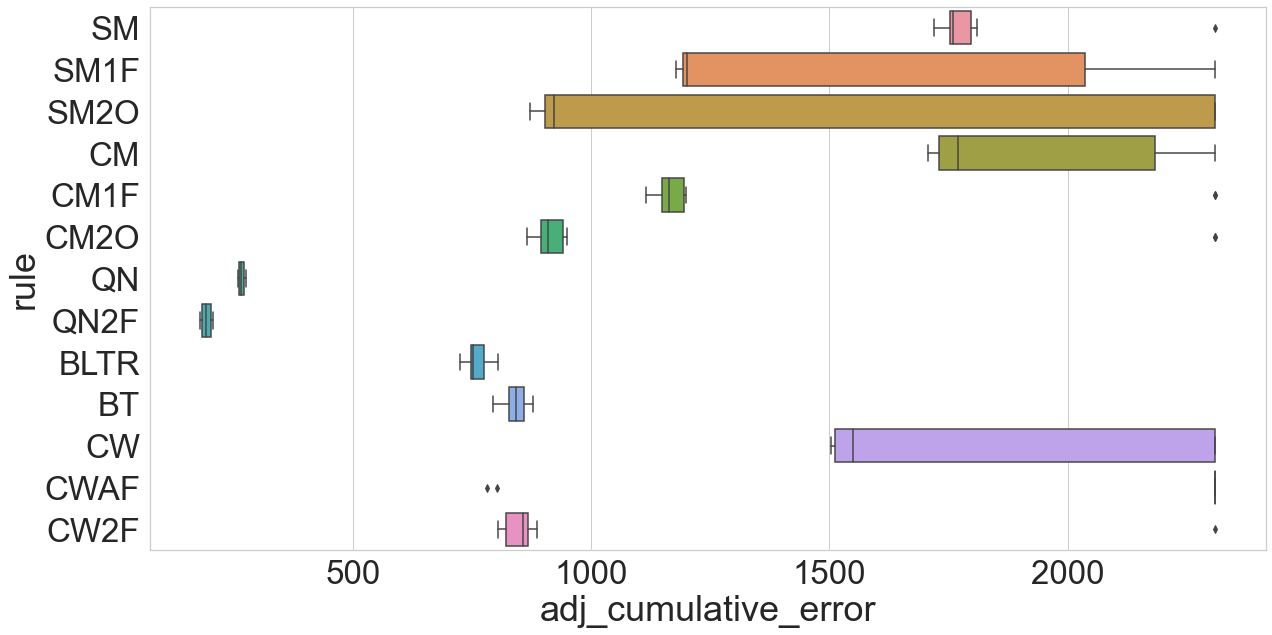

In [12]:
sns.set(font_scale=3)
sns.set_style("whitegrid")

fig=plt.figure(constrained_layout=False,figsize=(20,10))
sns.boxplot(data=final_nonan,x='adj_cumulative_error',y='rule',order=chosen_rules)

<AxesSubplot:xlabel='adj_cumulative_error', ylabel='Proportion'>

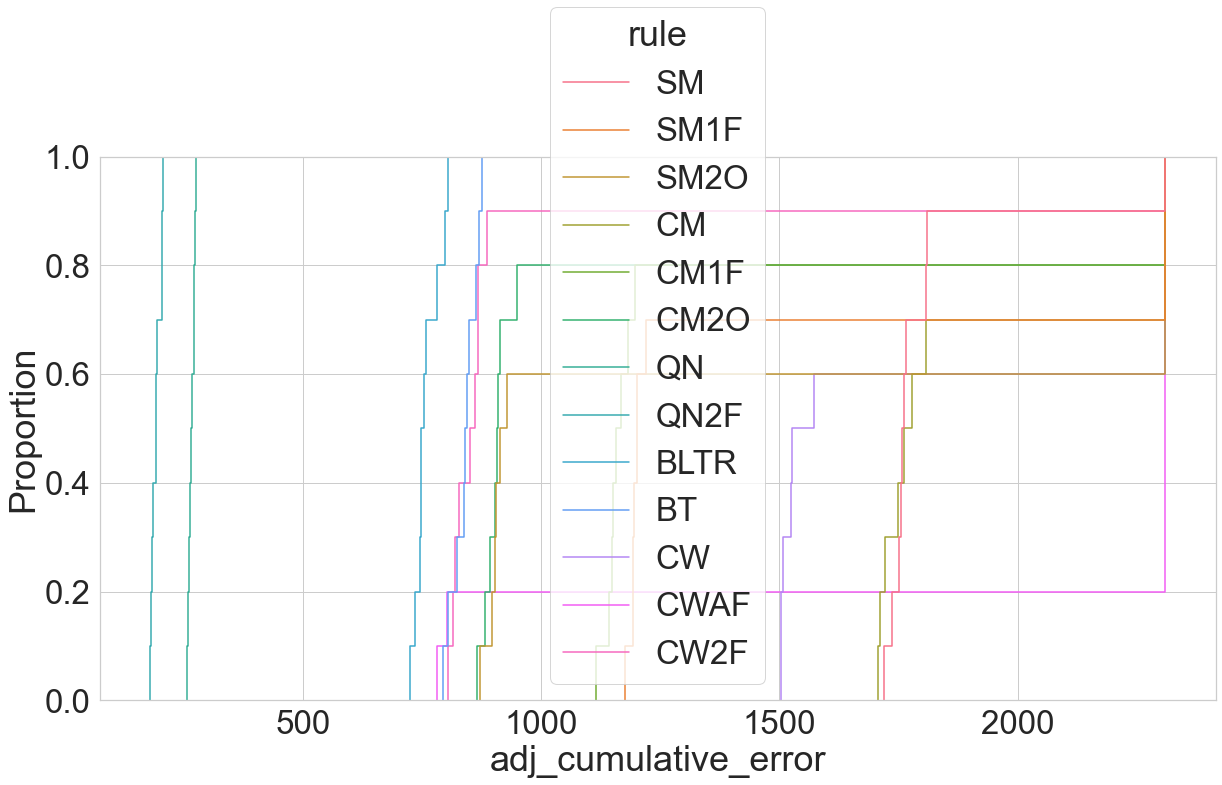

In [13]:
sns.set(font_scale=3)
sns.set_style("whitegrid")

fig=plt.figure(constrained_layout=False,figsize=(20,10))
sns.ecdfplot(data=final_nonan,x='adj_cumulative_error',hue='rule',hue_order=chosen_rules)